# Esfandiar Kiani

## Deep Learning - HM01 - Part 2.1 (Classification From Scratch)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [3]:
FILE_PATH = "D:/M.A/T2/Deep Learning/Assignments/HM1 - Es.Kiani - 40311614/Wine.xlsx"
INPUT_SIZE = 13
HIDDEN1_SIZE = 64
HIDDEN2_SIZE = 32
HIDDEN3_SIZE = 16
OUTPUT_SIZE = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATES = [0.05, 0.04, 0.03, 0.02]
TRAIN_RATIO = 0.75
SEED = 13

### Dataset class

In [4]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).to(device)
        self.y = torch.LongTensor(y).to(device)  # Use LongTensor for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Load data

In [5]:
data = pd.read_excel(FILE_PATH, header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values - 1

### Normalize

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Split dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-TRAIN_RATIO, random_state=SEED)

### DataLoaders

In [8]:
train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Neural Network

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden1_size)
        self.layer2 = nn.Linear(hidden1_size, hidden2_size)
        self.layer3 = nn.Linear(hidden2_size, hidden3_size)
        self.layer_out = nn.Linear(hidden3_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        x = self.layer_out(x)
        x = self.softmax(x) 
        return x

### Model

In [10]:
model = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, HIDDEN3_SIZE, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss() 

### Optimizers for each layer with different learning rates

In [11]:
optimizer_layer1 = optim.SGD(model.layer1.parameters(), lr=LEARNING_RATES[0])
optimizer_layer2 = optim.SGD(model.layer2.parameters(), lr=LEARNING_RATES[1])
optimizer_layer3 = optim.SGD(model.layer3.parameters(), lr=LEARNING_RATES[2])
optimizer_out = optim.SGD(model.layer_out.parameters(), lr=LEARNING_RATES[3])

### Train

In [12]:
train_losses = []
test_losses = []

In [13]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer_layer1.step()
        optimizer_layer2.step()
        optimizer_layer3.step()
        optimizer_out.step()
        
        optimizer_layer1.zero_grad()
        optimizer_layer2.zero_grad()
        optimizer_layer3.zero_grad()
        optimizer_out.zero_grad()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on test set
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

### Evaluation

In [16]:
train_preds, train_labels = [], []
test_preds, test_labels = [], []

In [17]:
model.eval()

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

### Result

In [18]:
train_accuracy = np.mean(np.array(train_preds) == np.array(train_labels))
test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels))

train_loss_final = np.mean(train_losses[-1])
test_loss_final = np.mean(test_losses[-1])

In [19]:
print(f"Final Training Loss: {train_loss_final:.4f}")
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Test Loss: {test_loss_final:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Training Loss: 0.9738
Final Training Accuracy: 0.8722
Final Test Loss: 0.9817
Final Test Accuracy: 0.9333


### Plot

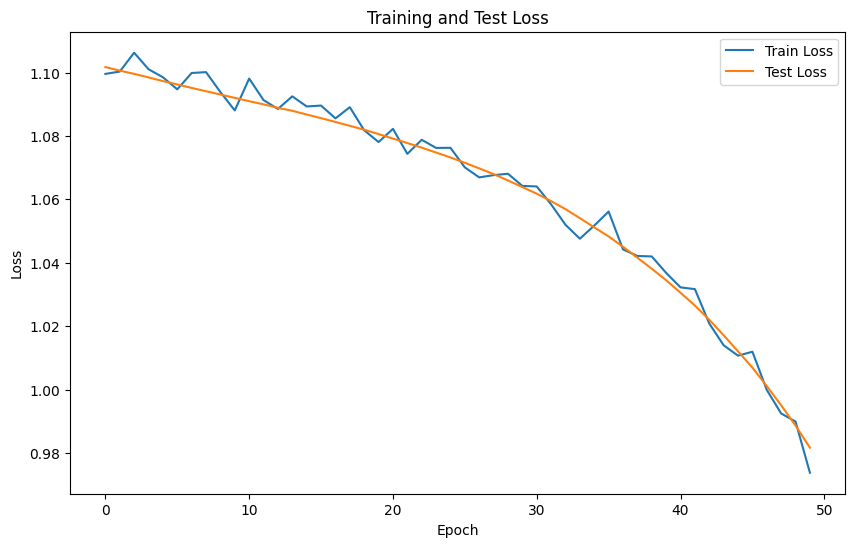

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

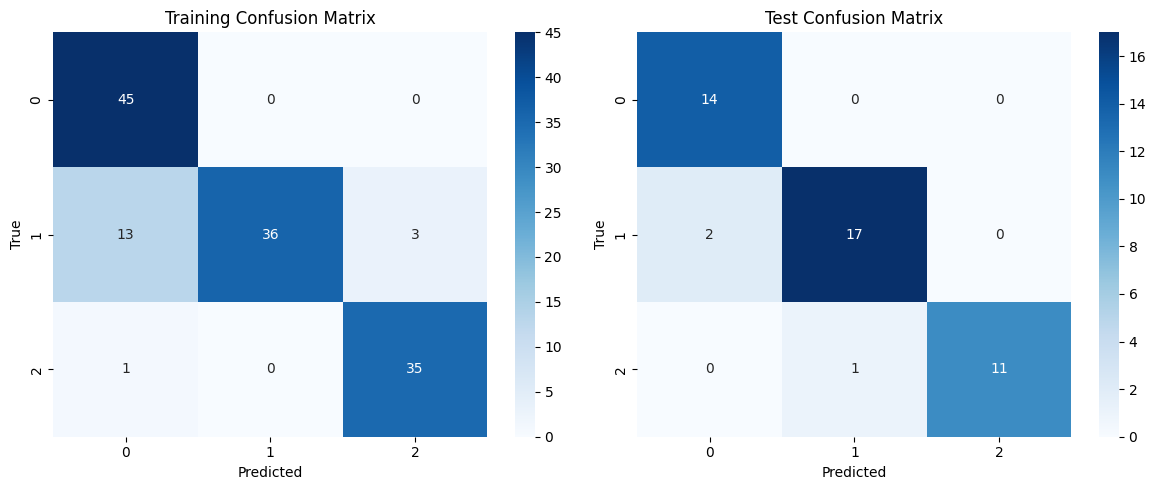

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_train = confusion_matrix(train_labels, train_preds)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_test = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()